In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [3]:
from stationq.mplplots.init_nb_plotting import *
from stationq.mplplots import plots as mplplots
from stationq.mplplots import tools as mpltools

In [4]:
from quantum_capacitance import rf; reload(rf)
from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [5]:
%run init.py

2018-01-15 11:34:28,037 : measurement : INFO : Logger set up!


Initialized IVVI-rack in 0.37s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.05s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.03s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [6]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

# Definitions

# Experiments

## Test: alazar time trace

In [ ]:
%run -i snippets/alazar_timetrace.py

## RF reflectometry

In [7]:
t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

(-879, -574, -879)

In [42]:
class AWGGateSweep2D(AWG2DRamp, AlazarMeasurementExt):
    
    data_cls = GridData
    
    def setup(self):
        super().setup()
        self.station.LO.frequency(self.station.RF.frequency() + self.IF())
        
        self.alazar_axes = OrderedDict({
            'Gate 1 (V)' : np.linspace(self.ramp_min[0], self.ramp_max[0], self.ramp_pts[0]),
            'Line Repetition' : np.arange(self.line_reps),
            'Gate 2 (V)' : np.linspace(self.ramp_min[1], self.ramp_max[1], self.ramp_pts[1]),
        })
    
    def measure(self):
        A, B = self.acquire()
        A2 = A[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])
        B2 = B[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])
        
        amp = np.abs(B2)
        phase = np.angle(A2*B2.conj(), deg=True)
        
        ret = OrderedDict({
            'amp' : {'value' : amp},
            'phase' : {'value' : phase},
        })
        
        axgrid = np.meshgrid(*[v for k, v in self.alazar_axes.items()], indexing='ij')
        for i, k in enumerate(self.alazar_axes):
            ret[k] = {'value' : axgrid[i].T, 'independent_parameter' : True}
            
        self.data.add(ret)

In [57]:
namespace.ats_settings['sample_rate'] = int(1e8)
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'
namespace.awg_settings['sampling_rate'] = int(1e7)
namespace.awg_settings['channel_1']['analog_amplitude'] = 4.0
namespace.awg_settings['channel_2']['analog_amplitude'] = 0.2
station.fg.ch1_frequency(0.5)
station.fg.ch1_output_enabled(False)
# station.RF.frequency(538.2e6)
station.RF.frequency(1.398e9)
station.RF.power(-35)
station.LO.power(22)

In [58]:
t1 = -880.
t2 = -574.
t3 = -880.

# for t2 in -540. + np.arange(0, -61, -2):

station.ivvi.dac4(t1)
station.ivvi.dac5(t2)
station.ivvi.dac6(t3)
station.fg.ch1_output_enabled(False)

info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

m = AWGGateSweep2D(station, namespace, info_string=info)
m.trigger_src = station.fg
m.trigger_chan = 'ch2_m1'

m.ramp_chan = (2, 1)
m.ramp_pts = (90, 80)
m.ramp_min = (0, 0)
m.ramp_max = (0.1, 1)
m.ramp_elt_len = 0.1e-3
m.ramp_down_len = 1e-3
m.line_reps = 10

m.IF(20e6)
m.ats_int_time(80e-6)
m.ats_integrate_samples(True)
m.ats_average_records(False)
m.ats_average_buffers(False)
m.ats_records_per_buffer(m.ramp_pts[0])
m.ats_buffers_per_acquisition(m.ramp_pts[1] * m.line_reps)
m.ats_demod(True)

m.do_setup_awg = False
m.run()

2018-01-15 15:28:17,503 : measurement : INFO : Ready to measure, file location: d:\data\2018-01\2018-01-15\2018-01-15_AWGGateSweep2D-#0010_t1=-880_t2=-574_t3=-880...


Instrument alazar_ctl already exists.


delay is less than recommended for filter choice: (expect delay >= 1e-06)
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:1097: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
2018-01-15 15:32:42,356 : measurement : INFO : Measurement finished, cleaning up...
2018-01-15 15:32:42,778 : measurement : INFO : All done!


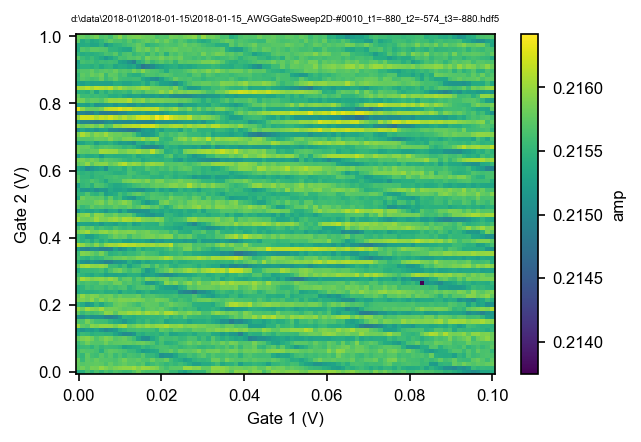

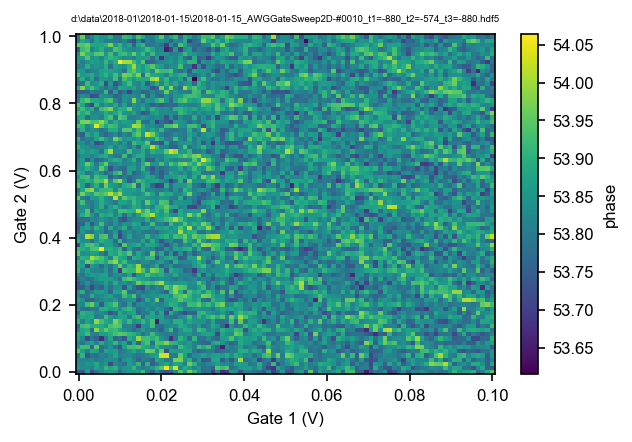

In [60]:
names = [n for n in m.data._pages.keys() if type(n) == str]
for zname in names:
    # Here I use the second dimension (line reps) as a simple 50 Hz filter.
    z, [(xname, x), (_, _), (yname, y)] = m.data[zname]
    fig, ax = plt.subplots(1, 1)
    im = mplplots.ppcolormesh(ax, x, y, z[:,:,:].mean(axis=1).T)
    cb = fig.colorbar(im)
    cb.set_label(zname)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(m.data.filepath, size='xx-small')
    fig.savefig(m.data_prefix + f"_{zname}.png", dpi=300, transparent=False)
#     plt.close('all')

In [37]:
class MultiFrqGateSweep(AWGGateSweep2D):
    
    RF_frqs = [538.2e6, 1.398e9]
    RF_pwrs = [[-60.,], [-35.,]]
    
    def measure(self):
        
        ret = OrderedDict({})
        axgrid = np.meshgrid(*[v for k, v in self.alazar_axes.items()], indexing='ij')
        for i, k in enumerate(self.alazar_axes):
            ret[k] = {'value' : axgrid[i].T, 'independent_parameter' : True}
        
        for frq, pwr_lst in zip(self.RF_frqs, self.RF_pwrs):
            for pwr in pwr_lst:
                suffix = f"{frq*1e-9:.4f}GHz_{pwr}dBm"
                
                self.station.RF.frequency(frq)
                self.station.RF.power(pwr)
                self.station.LO.frequency(self.station.RF.frequency() + self.IF())
                time.sleep(0.5)
                
                A, B = self.acquire()
                A2 = A[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])
                B2 = B[:].reshape(self.ramp_pts[1], self.line_reps, self.ramp_pts[0])

                amp = np.abs(B2)
                phase = np.angle(A2*B2.conj(), deg=True)
                ret[f'amp_{suffix}'] = {'value' : amp}
                ret[f'phase_{suffix}'] = {'value' : phase}

        self.data.add(ret)

In [38]:
t1 = -880.
t2 = -574.
t3 = -880.

# for t2 in -540. + np.arange(0, -61, -2):

station.ivvi.dac4(t1)
station.ivvi.dac5(t2)
station.ivvi.dac6(t3)
station.fg.ch1_output_enabled(False)

info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

m = MultiFrqGateSweep(station, namespace, info_string=info)
m.trigger_src = station.fg
m.trigger_chan = 'ch2_m1'

m.ramp_chan = (2, 1)
m.ramp_pts = (90, 80)
m.ramp_min = (0, 0)
m.ramp_max = (0.1, 1)
m.ramp_elt_len = 0.1e-3
m.ramp_down_len = 1e-3
m.line_reps = 2

m.RF_frqs = [538.2e6, 1.040e9]
m.RF_pwrs = [[-60,], [-35,]]

m.IF(20e6)
m.ats_int_time(80e-6)
m.ats_integrate_samples(True)
m.ats_average_records(False)
m.ats_average_buffers(False)
m.ats_records_per_buffer(m.ramp_pts[0])
m.ats_buffers_per_acquisition(m.ramp_pts[1] * m.line_reps)
m.ats_demod(True)

m.do_setup_awg = False
m.run()

2018-01-15 14:41:46,444 : measurement : INFO : Ready to measure, file location: d:\data\2018-01\2018-01-15\2018-01-15_MultiFrqGateSweep-#0003_t1=-880_t2=-574_t3=-880...


Instrument alazar_ctl already exists.


delay is less than recommended for filter choice: (expect delay >= 1e-06)
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:1097: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
2018-01-15 14:42:42,837 : measurement : INFO : Measurement finished, cleaning up...
2018-01-15 14:42:43,026 : measurement : INFO : All done!


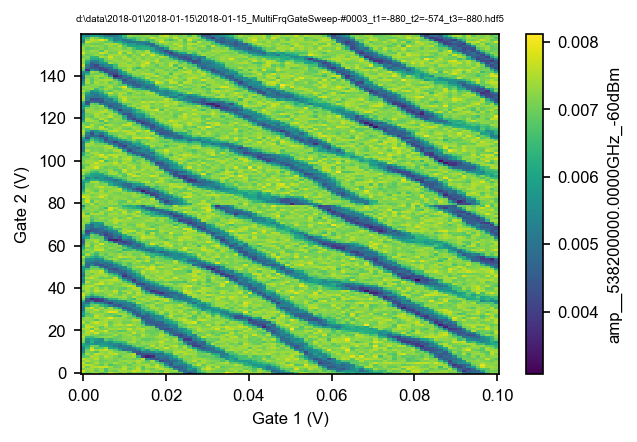

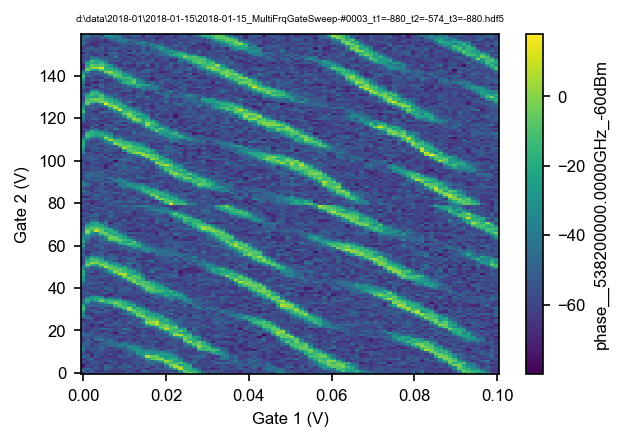

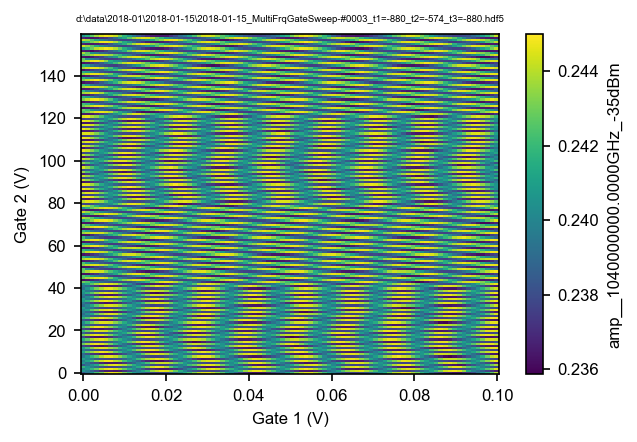

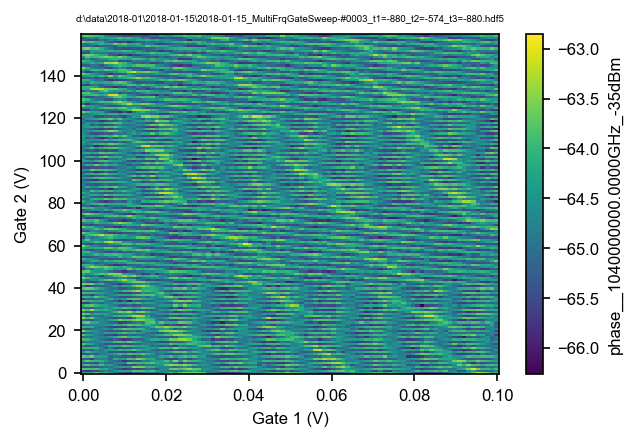

In [41]:
names = [n for n in m.data._pages.keys() if type(n) == str]
for zname in names:
    # Here I use the second dimension (line reps) as a simple 50 Hz filter.
    z, [(xname, x), (_, _), (yname, y)] = m.data[zname]
    fig, ax = plt.subplots(1, 1)
    im = mplplots.ppcolormesh(ax, x, np.arange(2 * y.size), z[:,:,:].reshape(x.size, y.size*2).T)
    cb = fig.colorbar(im)
    cb.set_label(zname)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(m.data.filepath, size='xx-small')
#     fig.savefig(m.data_prefix + f"_{zname}.png", dpi=300, transparent=False)
    
#     plt.close('all')

### Stability Diagram

In [ ]:
start = 0
stop = 2000
pts = 51
navg = 1


RF_frq = 538.2e6
RF_pwr = -65
t_int = 80e-6

station.fg.ch1_frequency(50)

# RF_frq = 1.040e9
# RF_frq = 1.398e9
# RF_pwr = -35
# t_int = 1.2e-3
 
# LO_pwr = 10 # use for IQ mixer
LO_pwr = 22 # use for interferometer

station.RF.frequency(RF_frq)
station.RF.power(RF_pwr)
station.LO.power(LO_pwr)

# make sure we trigger externally
namespace.ats_settings['trigger_source1'] = 'EXTERNAL'

# set sampling rate of the alazar
namespace.ats_settings['sample_rate'] = int(1e8)

# awg as low sampling as possible
namespace.awg_settings['sampling_rate'] = int(1e7)

# limit awg output
namespace.awg_settings['channel_2']['analog_amplitude'] = 0.2

In [ ]:
t1 = -855
t2 = -640
t3 = -875
station.ivvi.dac4(t1) # T1
station.ivvi.dac5(t2) # T2
station.ivvi.dac6(t3) # T3

t1, t2, t3 = int(station.ivvi.dac4()), int(station.ivvi.dac5()), int(station.ivvi.dac6())
t1, t2, t3

In [ ]:
# for RF_pwr in np.array([-50., -45., -40., -35., -30., -25., -20., -15., ]):
# for t2 in (-700.0 - np.arange(5) * 2.0):
info = None
# info = f'pwr={RF_pwr}'
# info = f'IF={IF}'
info = f't1={int(t1)}_t2={int(t2)}_t3={int(t3)}'

# create measurement class and run
m = AWGGateSweep(station, namespace, info_string=info)
m.awg_chan(2)
m.ramp_pts(200)
m.max_val(0.1)
m.ramp_down_len(1e-3)
m.ats_int_time(t_int)
m.navgs(navg)
m.IF(20e6)

m.sweep = [
    (m.station.ivvi.dac7, np.linspace(start, stop, pts))
]
m.run()

for zname in ['delta_phase', 'chanB_abs']:
    z, [(xname, x), (yname, y)] = m.data[zname]
    fig, ax = plt.subplots(1,1)
    im = mplplots.ppcolormesh(ax, x, y, z.T)
    cb = fig.colorbar(im)
    cb.set_label(zname)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(m.data.filepath, size='x-small')
    fig.savefig(m.metadata_prefix + f"_{zname}.png", dpi=300, transparent=False)

In [ ]:
ivvi.set_dacs_zero()